In [1]:
import pandas as pd
import numpy as np
import re
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Suicide_Detection.csv', engine='python')


In [3]:
df = pd.get_dummies(df, columns = ['class'], drop_first = True)

In [4]:
df = df.iloc[:,1:]

In [5]:
df = df.iloc[220000:]


In [6]:
df.shape

(12074, 2)

In [7]:
#Importamos librerias para trabajar sobre text mining
from nltk import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
# Defining Features Matrix
X = df.drop(['class_suicide'], axis=1)
X.head()

,text
220000,My inability to sleep... ...It is frightening....
220001,I just woke up at 2 pm hows your day going?
220002,I want more snap streaks so I can see cute boi...
220003,I read an interesting article on notesI starte...
220004,The horrors of the climbing unit in Gym class ...


In [9]:
# Define Target
y = df['class_suicide']
y.head()

220000    0
220001    0
220002    0
220003    1
220004    0
Name: class_suicide, dtype: uint8

In [10]:
# Separate training and testing sets, stratifying by class
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [11]:
#Vamos a limpiar los datos de train y test
#Usamos Tokennizer que elimine los signos de puntuación y tags html
#Hacemos stemming para obtener las raices de las palabras en minusculas
#Eliminamos stopwords

In [12]:
def clean_reddit(text, tokenizer, stemmer, stopwords):
    
    #tokens (eliminamos todos los signos de puntuación)
    words = tokenizer.tokenize(text)
    
    #Stemming : raiz y minusculas:
    stem_words = [stemmer.stem(x) for x in words]
    
    #eliminamos stopwords (ya pasaron por stem)
    clean_words = [x for x in stem_words if x not in stopwords]
    
    result = " ".join(clean_words)
    
    return(result)

In [13]:
#Importing for stepwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Equipo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
#Eliminamos signos de puntuacion

tokenizer = RegexpTokenizer(r"\w+")

englishStemmer = SnowballStemmer("english")
stopwords_en = stopwords.words('english')
stopwords_en_stem = [englishStemmer.stem(x) for x in stopwords_en]

In [15]:
clean_train = [clean_reddit(x, tokenizer, englishStemmer, stopwords_en_stem) for x in X_train.text]

In [16]:
clean_test = [clean_reddit(x, tokenizer, englishStemmer, stopwords_en_stem) for x in X_test.text]

In [17]:
#CountVectorizer para transformar los datos de train y test

count_vectorizer = CountVectorizer()
count_vectorizer.fit(clean_train)
X_train_sparse = count_vectorizer.transform(clean_train)
X_test_sparse = count_vectorizer.transform(clean_test)

In [18]:
X_train = pd.DataFrame(X_train_sparse.todense(), 
             columns = count_vectorizer.get_feature_names())

In [19]:
X_test = pd.DataFrame(X_test_sparse.todense(), 
             columns = count_vectorizer.get_feature_names()) 

In [20]:
#Entrenamos NB

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [22]:
# Seleccionamos el modelo
model = GaussianNB()

In [24]:
model.fit(X_train, y_train)

GaussianNB()

In [25]:
ypred = model.predict(X_test)
ypred

array([0, 1, 0, ..., 0, 1, 1], dtype=uint8)

In [26]:
ypred_prob = model.predict_proba(X_test)

In [29]:

accuracy_score(y_test, ypred)

0.7452798940046373

Text(51.0, 0.5, 'True Value')

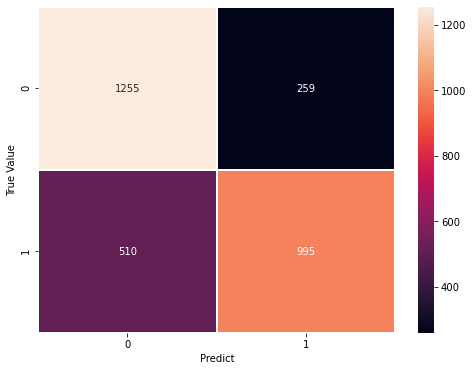

In [30]:
# Calculamos la matriz de confusión
conf_mat = confusion_matrix(y_test, ypred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,linecolor='w',linewidths=1,annot=True,fmt='d')
plt.xlabel('Predict')
plt.ylabel('True Value')

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77      1514
           1       0.79      0.66      0.72      1505

    accuracy                           0.75      3019
   macro avg       0.75      0.75      0.74      3019
weighted avg       0.75      0.75      0.74      3019



In [32]:
#Cross val NB 3 folds

In [33]:
# Importamos la función cross_val_score del módulo de selección de modelos
from sklearn.model_selection import cross_val_score

# La ejecutamos indicando como estimador GaussianNB, especificando el set de train y cuántos folds queremos
cross_val_score(estimator=GaussianNB(), X=X_train, y=y_train, cv=3)

array([0.74395495, 0.75612989, 0.74884029])

In [35]:
cross_val_score(estimator=GaussianNB(), X=X_train, y=y_train, cv=3).mean()

0.7496417102990977

In [36]:
#Cross val NB 10 folds

In [38]:
cross_val_score(estimator=GaussianNB(), X=X_train, y=y_train, cv=10)

array([0.75275938, 0.73620309, 0.74172185, 0.76490066, 0.75275938,
       0.74917127, 0.75911602, 0.75027624, 0.75138122, 0.74143646])